<a href="https://colab.research.google.com/github/Teodosiodg2002/Diabetes-Classification/blob/main/DiabetesClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Librerías y Configuración Global
Todo lo que se importa va al principio. Definimos las constantes (rutas, semillas) arriba para no tener "números mágicos" escondidos en el código.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             classification_report, RocCurveDisplay)

# Configuración Global
CONFIG = {
    'FILENAME': 'diabetes.csv',
    'SEP': ';',
    'TARGET': 'Diabetes_binary',
    'SEED': 42,
    'TEST_SIZE': 0.2,    # 20% para Test final
    'VAL_SIZE': 0.15     # 15% para Validación (del total)
}

# Estilo de gráficas
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Funciones de Carga y Pre-procesamiento
Aquí encapsulamos la lógica. La función preprocess_data: ahora devuelve los 3 conjuntos limpios y listos. Esto cumple con el requisito de limpieza y tratamiento de nulos .

In [11]:
# ==========================================
# 2. FUNCIONES DE CARGA Y LIMPIEZA
# ==========================================

def load_data(filename, sep):
    """Carga datos y gestiona valores centinela."""
    try:
        df = pd.read_csv(filename, sep=sep)
        print(f"📂 Dataset cargado: {df.shape}")

        # Tratamiento de nulos especificado en la práctica (-999 a NaN)
        df.replace(-999, np.nan, inplace=True)

        # Imputación por mediana (Estrategia robusta)
        if df.isnull().sum().sum() > 0:
            df.fillna(df.median(), inplace=True)
            print("✨ Valores nulos imputados por la mediana.")

        return df
    except FileNotFoundError:
        print("❌ Error: Archivo no encontrado.")
        return None

def preprocess_and_split(df, target_col):
    """Normaliza numéricos y divide en Train/Val/Test."""

    # 1. Normalización Min-Max (solo numéricas no binarias)
    scaler = MinMaxScaler()
    cols_to_scale = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']

    df_scaled = df.copy()
    # Verificamos que las columnas existan antes de escalar
    cols_existentes = [c for c in cols_to_scale if c in df.columns]
    df_scaled[cols_existentes] = scaler.fit_transform(df[cols_existentes])

    # 2. Separación X / y
    X = df_scaled.drop(target_col, axis=1)
    y = df_scaled[target_col]

    # 3. División: Train (70%) - Temp (30%)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=CONFIG['SEED'], stratify=y
    )

    # 4. División: Val (15%) - Test (15%)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=CONFIG['SEED'], stratify=y_temp
    )

    print(f"📊 División completada:")
    print(f"   - Train: {X_train.shape[0]} muestras")
    print(f"   - Val:   {X_val.shape[0]} muestras")
    print(f"   - Test:  {X_test.shape[0]} muestras")

    return X_train, X_val, X_test, y_train, y_val, y_test

## 3. Función Maestra de Evaluación
Esta es la "joya" del código limpio. En lugar de repetir código para cada modelo, creamos una función que recibe un modelo, lo entrena y saca todas las gráficas .

In [12]:
def train_and_evaluate(model, X_train, y_train, X_val, y_val, model_name="Modelo"):
    """
    1. Entrena el modelo.
    2. Realiza Cross-Validation.
    3. Muestra métricas y gráficas en el conjunto de Validación.
    """
    print(f"\n🚀 Entrenando {model_name}...")

    # A. Cross-Validation (5 Folds) para verificar estabilidad
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=CONFIG['SEED'])
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    print(f"   - Accuracy CV (Media): {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

    # B. Entrenamiento final
    model.fit(X_train, y_train)

    # C. Evaluación en Validación
    acc_val = model.score(X_val, y_val)
    print(f"   - Accuracy Validation: {acc_val:.4f}")

    # D. Gráficas
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Matriz de Confusión
    ConfusionMatrixDisplay.from_estimator(model, X_val, y_val, cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Matriz de Confusión - {model_name}')
    axes[0].grid(False)

    # Curva ROC
    RocCurveDisplay.from_estimator(model, X_val, y_val, ax=axes[1], name=model_name)
    axes[1].set_title(f'Curva ROC - {model_name}')
    axes[1].plot([0, 1], [0, 1], 'r--', label='Azar')

    plt.tight_layout()
    plt.show()

    return model

## 4. Ejecución Principal (Main Loop)
Aquí es donde "ocurre la magia". Es limpio, corto y fácil de leer.

📂 Dataset cargado: (60796, 22)
✨ Valores nulos imputados por la mediana.
📊 División completada:
   - Train: 42557 muestras
   - Val:   9119 muestras
   - Test:  9120 muestras

🚀 Entrenando Árbol de Decisión...
   - Accuracy CV (Media): 0.7231 (+/- 0.0071)
   - Accuracy Validation: 0.7233


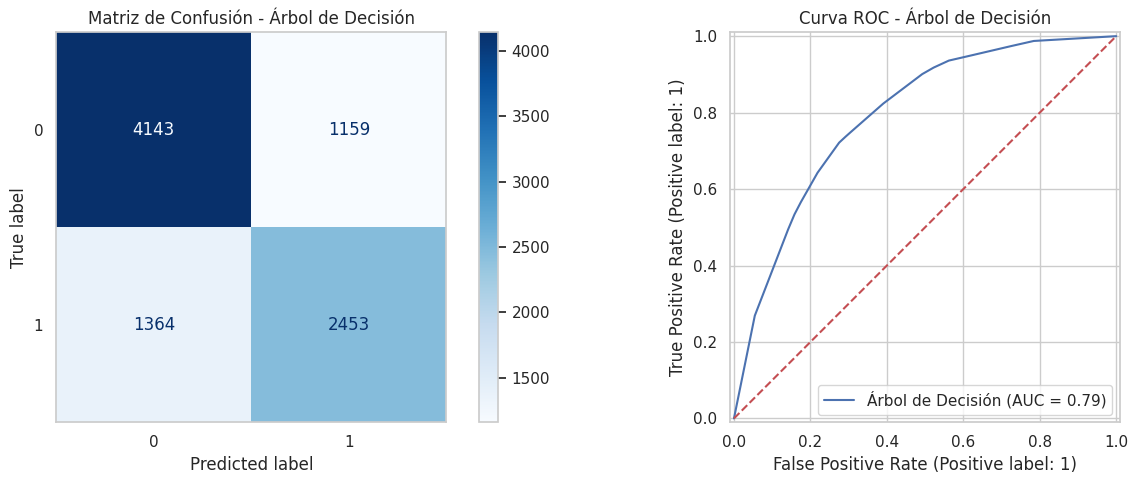


🚀 Entrenando Random Forest...
   - Accuracy CV (Media): 0.7457 (+/- 0.0095)
   - Accuracy Validation: 0.7481


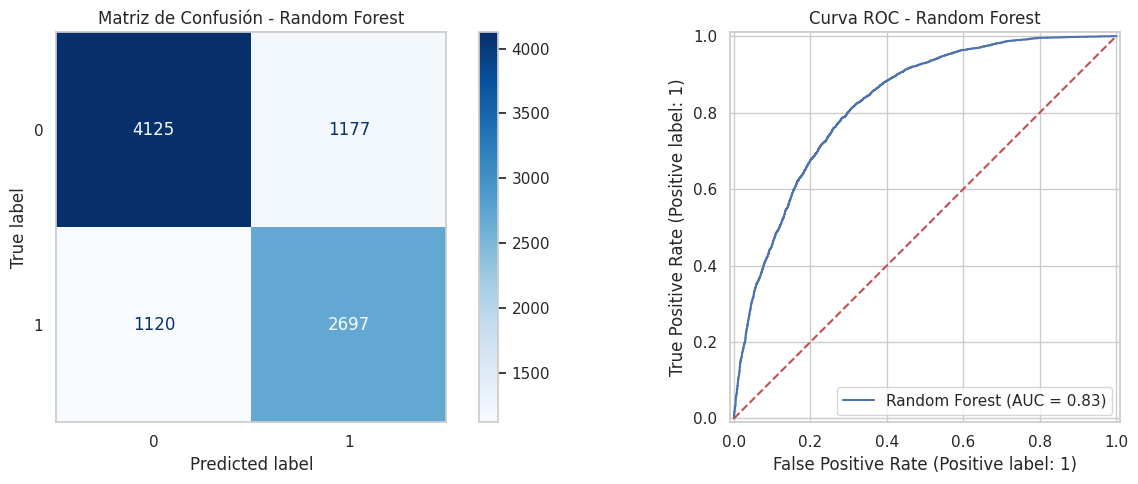


⚔️ Comparativa Final de Modelos


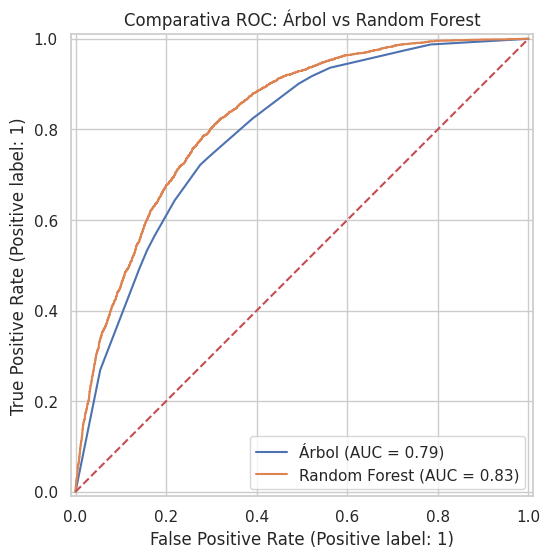

In [13]:
# 1. Carga
df = load_data(CONFIG['FILENAME'], CONFIG['SEP'])

if df is not None:
    # 2. Pre-procesamiento
    X_train, X_val, X_test, y_train, y_val, y_test = preprocess_and_split(df, CONFIG['TARGET'])

    # 3. Definición de Modelos
    # Árbol de decisión simple
    tree_clf = DecisionTreeClassifier(max_depth=4, criterion='gini', random_state=CONFIG['SEED'])

    # Random Forest robusto
    rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=CONFIG['SEED'], n_jobs=-1)

    # 4. Entrenamiento y Evaluación (¡Mira qué limpio queda!)
    model_tree = train_and_evaluate(tree_clf, X_train, y_train, X_val, y_val, "Árbol de Decisión")
    model_rf = train_and_evaluate(rf_clf, X_train, y_train, X_val, y_val, "Random Forest")

    # 5. (Opcional) Comparativa Visual Final
    print("\n⚔️ Comparativa Final de Modelos")
    fig, ax = plt.subplots(figsize=(8, 6))
    RocCurveDisplay.from_estimator(model_tree, X_val, y_val, ax=ax, name='Árbol')
    RocCurveDisplay.from_estimator(model_rf, X_val, y_val, ax=ax, name='Random Forest')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title("Comparativa ROC: Árbol vs Random Forest")
    plt.show()